In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vgg16, VGG16_Weights

In [16]:
# -------------------------
# Repro (optional)
# -------------------------
torch.manual_seed(42)
np.random.seed(42)

# -------------------------
# Device (T4)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: Tesla T4


In [33]:
# -------------------------
# Config
# -------------------------
NUM_CLASSES = 10
EPOCHS = 10
LR = 1e-4

BATCH_TRAIN = 64
BATCH_VAL = 256
BATCH_TEST = 256

NUM_WORKERS = 2  # safe on Colab
PIN_MEMORY = True if device.type == "cuda" else False

# CIFAR-10 mean/std (ok to keep)
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2023, 0.1994, 0.2010)

In [34]:
# -------------------------
# Transforms (VGG expects 224x224)
# -------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [35]:
# -------------------------
# Dataset: Split Train into Train/Val, keep official Test
# -------------------------
full_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

# For validation we should NOT use random augmentation, so we’ll clone the dataset with eval_transform
full_train_eval = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=False, transform=eval_transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=eval_transform
)

train_size = 45000
val_size = len(full_train) - train_size  # 5000

train_subset, val_subset_idx = random_split(full_train, [train_size, val_size])
# random_split returns subsets of the dataset object we pass; we need val subset based on same indices but eval transform
# So we reuse indices from val_subset_idx
val_subset = torch.utils.data.Subset(full_train_eval, val_subset_idx.indices)

trainloader = DataLoader(
    train_subset, batch_size=BATCH_TRAIN, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
valloader = DataLoader(
    val_subset, batch_size=BATCH_VAL, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
testloader = DataLoader(
    testset, batch_size=BATCH_TEST, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

print(f"Train samples: {len(train_subset)} | Val samples: {len(val_subset)} | Test samples: {len(testset)}")

Train samples: 45000 | Val samples: 5000 | Test samples: 10000


In [36]:
# -------------------------
# Model: VGG-16 pretrained + light fine-tuning
# -------------------------
model = vgg16(weights=VGG16_Weights.DEFAULT)

# Replace final classifier output
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)

# Freeze features first
for p in model.features.parameters():
    p.requires_grad = False

# Unfreeze last few layers inside features (light fine-tuning)
for p in model.features[-4:].parameters():
    p.requires_grad = True

# Classifier trainable
for p in model.classifier.parameters():
    p.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR
)

In [37]:
# Step on VAL accuracy (mode=max)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

# AMP (mixed precision) for T4 speed
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipython-input-2117038708.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [38]:
# -------------------------
# Helpers
# -------------------------
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

In [39]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc


In [40]:
# Confusion matrix without sklearn (pure torch/numpy)
@torch.no_grad()
def confusion_matrix(model, loader, num_classes, device):
    model.eval()
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for t, p in zip(labels.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
    return cm.cpu().numpy()

In [41]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()

    plt.show()

In [42]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (Test)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    # write numbers
    thresh = cm.max() * 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


In [43]:
# -------------------------
# Train loop
# -------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, trainloader, optimizer, criterion, device, scaler)
    va_loss, va_acc = evaluate(model, valloader, criterion, device)

    # scheduler step on VAL accuracy
    scheduler.step(va_acc)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    lr_now = optimizer.param_groups[0]["lr"]
    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
        f"Val Loss {va_loss:.4f} Acc {va_acc:.4f} | "
        f"LR {lr_now:.6f}"
    )

    # Save best model weights (optional)
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "vgg16_best.pth")

print("Best Val Acc:", best_val_acc)


/tmp/ipython-input-3007891216.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/tmp/ipython-input-3871041425.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 01/10 | Train Loss 0.5138 Acc 0.8211 | Val Loss 0.3791 Acc 0.8688 | LR 0.000100
Epoch 02/10 | Train Loss 0.2998 Acc 0.8979 | Val Loss 0.3325 Acc 0.8850 | LR 0.000100
Epoch 03/10 | Train Loss 0.2166 Acc 0.9260 | Val Loss 0.3185 Acc 0.8890 | LR 0.000100
Epoch 04/10 | Train Loss 0.1647 Acc 0.9440 | Val Loss 0.3118 Acc 0.8962 | LR 0.000100
Epoch 05/10 | Train Loss 0.1250 Acc 0.9567 | Val Loss 0.3183 Acc 0.8960 | LR 0.000100
Epoch 06/10 | Train Loss 0.1011 Acc 0.9660 | Val Loss 0.3545 Acc 0.8892 | LR 0.000100
Epoch 07/10 | Train Loss 0.0831 Acc 0.9724 | Val Loss 0.3693 Acc 0.8934 | LR 0.000100
Epoch 08/10 | Train Loss 0.0718 Acc 0.9755 | Val Loss 0.3746 Acc 0.8994 | LR 0.000100
Epoch 09/10 | Train Loss 0.0625 Acc 0.9787 | Val Loss 0.3828 Acc 0.8962 | LR 0.000100
Epoch 10/10 | Train Loss 0.0573 Acc 0.9808 | Val Loss 0.3795 Acc 0.8986 | LR 0.000100
Best Val Acc: 0.8994


/tmp/ipython-input-3871041425.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


TEST  Loss: 0.3955 | TEST  Acc: 0.8990


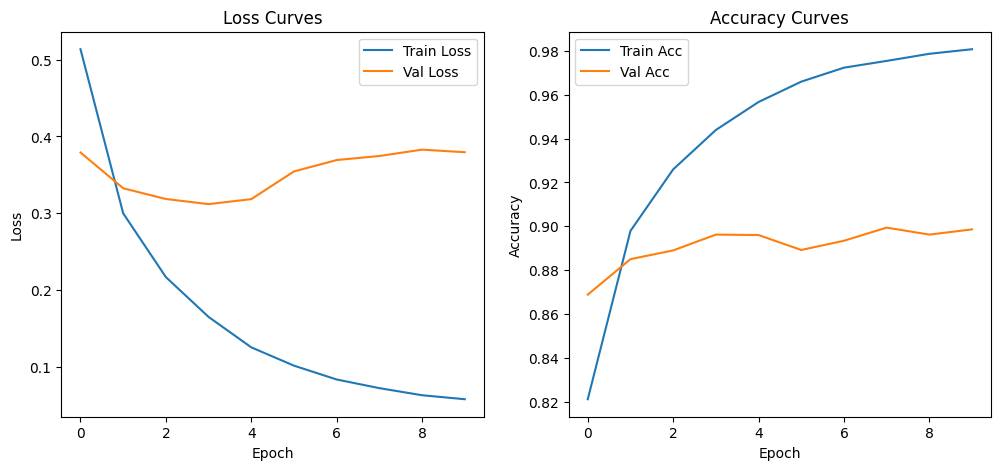

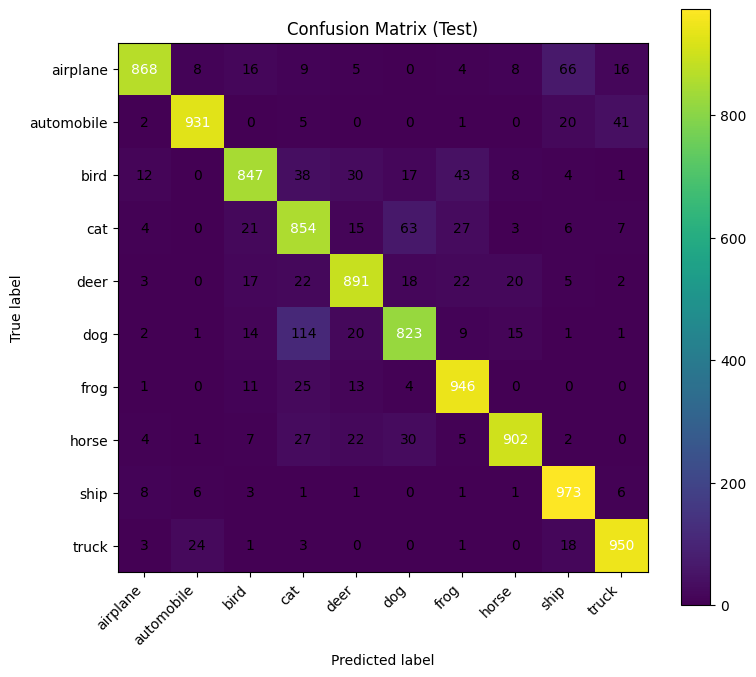

In [44]:
# -------------------------
# Final evaluation on TEST
# -------------------------
# Load best weights for test eval (optional but recommended)
if os.path.exists("vgg16_best.pth"):
    model.load_state_dict(torch.load("vgg16_best.pth", map_location=device))

test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f"TEST  Loss: {test_loss:.4f} | TEST  Acc: {test_acc:.4f}")

# -------------------------
# Curves
# -------------------------
plot_curves(train_losses, val_losses, train_accs, val_accs)

# -------------------------
# Confusion Matrix (TEST)
# -------------------------
classes = testset.classes  # CIFAR-10 class names
cm = confusion_matrix(model, testloader, NUM_CLASSES, device)
plot_confusion_matrix(cm, classes)